In [1]:
# Peter Nelson 30/9/19
# Code for use at the FASTBLADE facility, determining where to place hydraulic rams to best simulate desired loading on 
# testing specimen. This code has different modes for different inputs. One mode uses target shear & bending data and the
# other modes use only either target load, shear or bending data. The code uses a genetic algorithm to solve an objective
# function that is minimised when the difference between the desired and actual shear force distributions is at a global 
# minimum. The code implicitly ensures that the desired bending moment distribution is simulated by ensuring that the sum 
# of ratios required is achieved. The code also accepts inputs for how many rams are present in the sytem and upper and 
# lower bounds for ram positions.

# modularisable and adaptable elsewhere more than Jupyter
# consider scalability of time taken for code performance as number of nodes increases 20,200,2000

In [1]:
import pandas as pd
import numpy as np
data = pd.read_excel(r"C:\Users\Peter's 2nd Laptop\Documents\MATLAB\FB again\Matlab Code No Contraints\testdata.xlsx")
number_rams=4
print(data)

    radial position        Fx       Fy
0          0.000000  1241.850 -228.450
1        205.128205  1230.165 -230.970
2        615.384615  1227.285 -224.010
3       1025.641026  1215.285 -215.760
4       1435.897436  1194.600 -206.355
5       1846.153846  1165.680 -195.930
6       2256.410256  1128.990 -184.605
7       2666.666667  1084.965 -172.515
8       3076.923077  1034.055 -159.795
9       3487.179487   976.695 -146.565
10      3897.435897   913.350 -132.945
11      4307.692308   844.470 -119.085
12      4717.948718   770.505 -105.105
13      5128.205128   691.875  -91.140
14      5538.461538   609.060  -77.310
15      5948.717949   522.495  -63.765
16      6358.974359   432.630  -50.610
17      6769.230769   339.915  -37.980
18      7179.487179   244.800  -26.010
19      7589.743590   147.720  -14.835
20      8000.000000    49.125   -4.575


# Defining x, Fx, Fy

In [17]:
from numpy import interp

nodes=200
L=data['radial position'][len(data)-1]

x=list(range(0,nodes))
b=L/(nodes-1)
x[:] = [ __ * b for __ in x]

Fx=interp(x,data['radial position'],data['Fx'])
Fy=interp(x,data['radial position'],data['Fy'])

# look into the interpolation method

# Integrating & Defining Targets

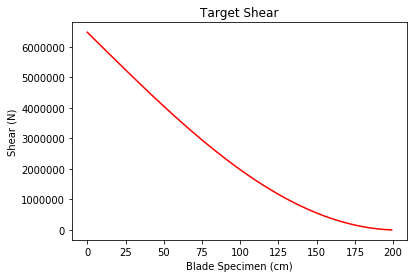

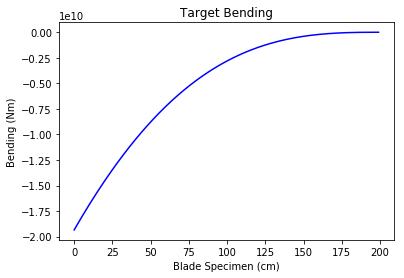

In [18]:
import scipy 
import numpy
from scipy import integrate
from numpy import append
from numpy import trapz
from numpy import insert
import matplotlib.pyplot as plt
%matplotlib inline  

integralpart=scipy.integrate.cumtrapz(Fx, x)
integralpart=numpy.insert(integralpart,0,0)
TF=integralpart[-1]

TargetShear=TF-integralpart[0]

for k in range(2,len(integralpart)):
    TargetShear=np.append(TargetShear,TF-integralpart[k-1])
TargetShear=np.append(TargetShear,0)

integralPart=scipy.integrate.cumtrapz(TargetShear,x)
integralPart=numpy.insert(integralPart,0,0)
bmax=integralPart[-1]

TargetBending=bmax-integralPart[0]

for k in range(2,len(integralPart)):
    TargetBending=np.append(TargetBending,bmax-integralPart[k-1])
TargetBending=np.append(TargetBending,0)
TargetBending=TargetBending*-1


plt.plot(TargetShear,'r')
plt.xlabel('Blade Specimen (cm)')
plt.ylabel('Shear (N)')
plt.title('Target Shear')
plt.show()

plt.plot(TargetBending,'b')
plt.xlabel('Blade Specimen (cm)')
plt.ylabel('Bending (Nm)')
plt.title('Target Bending')
plt.show()

# Using rules to get solver inputs

In [19]:
F=TF/number_rams;
SumRatios=number_rams*((max(abs(TargetBending))/max(TargetShear)))/L

Shear=[None]*(number_rams+1)
for i in range(0,number_rams+1):
    Shear[i]=TF-F*i
    
Shear=list(Shear)

# Creating Actual Shear Function 

In [20]:
def AcSh(x,sol,Shear):
    ActualShear=[]
    for j in range(0,len(Shear)):
        for i in range(0,len(x)-1):                              #-1 to fix something
            if (x[i])>=sol[j] and (x[i])<sol[j+1]:
                ActualShear=np.append(ActualShear, (Shear[j]))
    ActualShear=np.append(ActualShear,0)                          #new to ensure Actual Shear length = x length
    return ActualShear

# LSQ Function

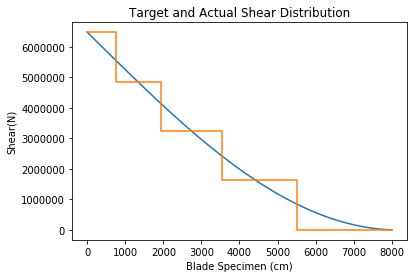

In [21]:
import matplotlib.pyplot as plt

#z=[0.0, 1600.0, 3200.0, 4800.0, 6400.0, 8000.0]
#zz=[6437606.4, 4497700.8, 2737797.6, 2737797.6, 1320496.8,0]

ActualShear=AcSh(x,[0, 750,1900,3500,5500,8000],Shear)

plt.plot(x, TargetShear)
plt.step(x, ActualShear, where='post')
plt.xlabel('Blade Specimen (cm)')
plt.ylabel('Shear(N)')
plt.title('Target and Actual Shear Distribution')
plt.show()

In [22]:
# list comprehensions are faster and cleaner, use more white space
def objective(x,Shear,sol,TargetShear):
    lsq_l=[]
    ActualShear=AcSh(x,sol,Shear)
    for i in range(0,len(x)):
        lsq_l=np.append(lsq_l, abs(ActualShear[i]-TargetShear[i]))
    return sum(lsq_l)

In [23]:
# compare speed of ^2 and ^0.5 to abs 
def objective2(x,Shear,sol,TargetShear):
    lsq_l=[None]*(len(x))
    ActualShear=AcSh(x,sol,Shear)
    for i in range(0,len(x)):
        lsq_l[i]= abs(ActualShear[i]-TargetShear[i])
        #print(lsq_l)
    return sum(lsq_l)

In [24]:
#checking abs(a-b) compared to **2)**.5
def objective3(x,Shear,sol,TargetShear):
    lsq_l=[None]*(len(x))
    ActualShear=AcSh(x,sol,Shear)
    for i in range(0,len(x)):
        lsq_l[i]= (((ActualShear[i]-TargetShear[i]))**2)**0.5
        #print(lsq_l)
    return sum(lsq_l)


# Data Frame Discussion

How to use panda data frames to improve code?
Could create dataframes for each input guess of sol, but this would only make things slower. The input data is originally input in a dataframe format, but is changed to standard Python list format soon after. The speed issue is more related to the objective function and the determination of the Actual Shear distribution for each sol input. Code is not slow up to this point, so even if it were possible, there would be no need to explore how to integrate and manipulate data in dataframe format?
Perhaps could store TargetShear and x as a dataframe but the issue we have is more likely to be related to the AcSh function and the objective function evaluation.

In [ ]:
print(objective(x,Shear,[0,1000,2500,5500,7500,8000],TargetShear))
print(objective(x,Shear,[0,1000,2500,5500,7500,8000],TargetShear))


# sol MUST begin at 0 and end at 8000

In [25]:
print(objective(x,Shear,[0, 1000,2500,5500,7500,8000],TargetShear))

188668399.38360143


In [26]:
print(objective2(x,Shear,[0, 1000,2500,5500,7500,8000],TargetShear))

188668399.38360143


In [27]:
print(objective3(x,Shear,[0,1000,2500,5500,7500,8000],TargetShear))

188668399.38360143


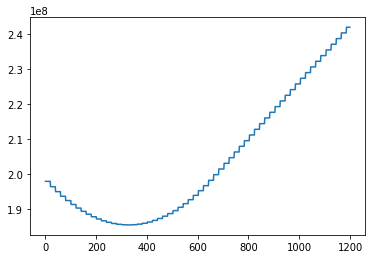

In [12]:
store=[]

for zz in range(1,2400,2):
    sol=[0,zz,2500,5500,7500,8000]
    value=objective3(x,Shear,sol,TargetShear)
    store=np.append(store, value)

    
import matplotlib.pyplot as plt
plt.plot(store)

# Solver Experimentation

In [7]:
z = np.linspace(0, 8, 10)

condlist=[z<5] # can include additional conds here
funclist=[0,1]



np.piecewise(z, condlist, funclist)

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

# Possible Data Input Structure

In [8]:
if 'Fx' in list(data):
    
    if 'Shear' in list(data):
        
        if 'Bending' in list(data):
            pass                        # All Three
       
    elif 'Bending' in list(data):
        pass                            # Fx & Bending
   
    else:
        print('load only')              # Fx Only
    
elif 'Shear' in list(data):
    
    if 'Bending' in list(data):
        pass                            # Shear & Bending
    
    else:
        pass                            # Shear Only
    
elif 'Bending' in list(data):
    pass                                # Bending Only

else:
    print('Error- no suitable input names!!')

load only


In [6]:
cd

C:\Users\Peter's 2nd Laptop
